## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# 本範例不需使用 GPU, 將 GPU 設定為 "無"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [20]:
# 從 Keras 的內建功能中，取得 train 與 test 資料集
train, test = keras.datasets.cifar10.load_data()

In [28]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [29]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [26]:
"""
建立神經網路，沒有加入 L1 或 L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
            x = keras.layers.Dropout(0.25)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

model = build_mlp(input_shape=x_train.shape[1:])
model.summary()

## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 10
BATCH_SIZE = 256
MOMENTUM = 0.95

optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True)



Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
output (Dense)               (None, 10)                1290

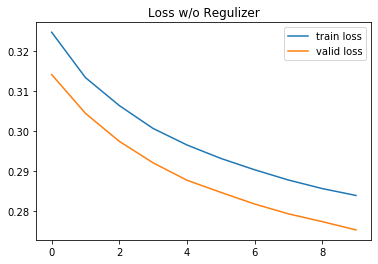

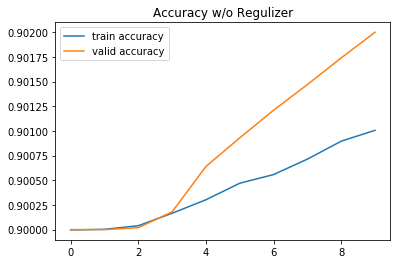

In [27]:
import matplotlib.pyplot as plt

train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]

train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss w/o Regulizer")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy w/o Regulizer")
plt.show()

In [32]:
"""
建立神經網路
"""
from keras.regularizers import l1, l2, l1_l2
import itertools

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=0.0, l2_ratio=0.0):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(x)
            x = keras.layers.Dropout(0.25)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [33]:
"""
帶 L1及L2 的模型並訓練
"""
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 10
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]

import itertools
results = {}
for l1r, l2r in itertools.product(L1_EXP, L2_EXP):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with L1 = %.6f, L2 = %.6f" % (l1r, l2r))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=l1r, l2_ratio=l2r)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l1-%s-l2-%s" % (str(l1r), str(l2r))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with L1 = 0.010000, L2 = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
output (Dense)

50000/50000 [==============================] - 9s 179us/step - loss: 0.4851 - accuracy: 0.9000 - val_loss: 0.4850 - val_accuracy: 0.9000
Epoch 9/10
50000/50000 [==============================] - 9s 175us/step - loss: 0.4851 - accuracy: 0.9000 - val_loss: 0.4851 - val_accuracy: 0.9000
Epoch 10/10
50000/50000 [==============================] - 9s 179us/step - loss: 0.4851 - accuracy: 0.9000 - val_loss: 0.4850 - val_accuracy: 0.9000
Experiment with L1 = 0.010000, L2 = 0.000000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
__________________________________________

50000/50000 [==============================] - 9s 185us/step - loss: 9.0346 - accuracy: 0.9000 - val_loss: 8.3246 - val_accuracy: 0.9000
Epoch 6/10
50000/50000 [==============================] - 9s 182us/step - loss: 7.7014 - accuracy: 0.9000 - val_loss: 7.0955 - val_accuracy: 0.9000
Epoch 7/10
50000/50000 [==============================] - 9s 185us/step - loss: 6.5644 - accuracy: 0.9000 - val_loss: 6.0475 - val_accuracy: 0.9000
Epoch 8/10
50000/50000 [==============================] - 9s 182us/step - loss: 5.5947 - accuracy: 0.9000 - val_loss: 5.1539 - val_accuracy: 0.9000
Epoch 9/10
50000/50000 [==============================] - 9s 186us/step - loss: 4.7680 - accuracy: 0.9000 - val_loss: 4.3923 - val_accuracy: 0.9000
Epoch 10/10
50000/50000 [==============================] - 9s 186us/step - loss: 4.0636 - accuracy: 0.9000 - val_loss: 3.7434 - val_accuracy: 0.9000
Experiment with L1 = 0.000100, L2 = 0.000100
Model: "model_1"
____________________________________________________________

50000/50000 [==============================] - 7s 131us/step - loss: 4.2199 - accuracy: 0.9000 - val_loss: 4.1789 - val_accuracy: 0.9000
Epoch 3/10
50000/50000 [==============================] - 7s 131us/step - loss: 4.1473 - accuracy: 0.9000 - val_loss: 4.1065 - val_accuracy: 0.9000
Epoch 4/10
50000/50000 [==============================] - 7s 131us/step - loss: 4.0764 - accuracy: 0.9000 - val_loss: 4.0359 - val_accuracy: 0.9000
Epoch 5/10
50000/50000 [==============================] - 7s 132us/step - loss: 4.0070 - accuracy: 0.9002 - val_loss: 3.9667 - val_accuracy: 0.9002
Epoch 6/10
50000/50000 [==============================] - 6s 129us/step - loss: 3.9389 - accuracy: 0.9004 - val_loss: 3.8988 - val_accuracy: 0.9005
Epoch 7/10
50000/50000 [==============================] - 6s 129us/step - loss: 3.8719 - accuracy: 0.9004 - val_loss: 3.8321 - val_accuracy: 0.9008
Epoch 8/10
50000/50000 [==============================] - 7s 131us/step - loss: 3.8058 - accuracy: 0.9005 - val_loss: 3.766

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 7s 139us/step - loss: 0.4650 - accuracy: 0.9000 - val_loss: 0.4535 - val_accuracy: 0.9000
Epoch 2/10
50000/50000 [==============================] - 7s 133us/step - loss: 0.4524 - accuracy: 0.9000 - val_loss: 0.4446 - val_accuracy: 0.9000
Epoch 3/10
50000/50000 [==============================] - 7s 133us/step - loss: 0.4453 - accuracy: 0.9000 - val_loss: 0.4376 - val_accuracy: 0.9000
Epoch 4/10
50000/50000 [==============================] - 7s 131us/step - loss: 0.4397 - accuracy: 0.9001 - val_loss: 0.4323 - val_accuracy: 0.9001
Epoch 5/10
50000/50000 [==============================] - 7s 132us/step - loss: 0.4356 - accuracy: 0.9003 - val_loss: 0.4280 - val_accuracy: 0.9004
Epoch 6/10
50000/50000 [==============================] - 7s 132us/step - loss: 0.4321 - accuracy: 0.9003 - val_loss: 0.4244 - val_accuracy: 0.9007
Epoch 7/10
50000/50000 [==============================] - 7s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 6s 121us/step - loss: 0.3255 - accuracy: 0.8999 - val_loss: 0.3124 - val_accuracy: 0.9000
Epoch 2/10
50000/50000 [==============================] - 6s 119us/step - loss: 0.3120 - accuracy: 0.9000 - val_loss: 0.3028 - val_accuracy: 0.9000
Epoch 3/10
50000/50000 [==============================] - 6s 117us/step - loss: 0.3048 - accuracy: 0.9000 - val_loss: 0.2959 - val_accuracy: 0.9000
Epoch 4/10
50000/50000 [==============================] - 6s 119us/step - loss: 0.2998 - accuracy: 0.9000 - val_loss: 0.2911 - val_accuracy: 0.9002
Epoch 5/10
50000/50000 [==============================] - 6s 117us/step - loss: 0.2958 - accuracy: 0.9002 - val_loss: 0.2872 - val_accuracy: 0.9006
Epoch 6/10
50000/50000 [==============================] - 6s 117us/step - loss: 0.2923 - accuracy: 0.9004 - val_loss: 0.2839 - val_accuracy: 0.9010
Epoch 7/10
50000/50000 [==============================] - 6s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 7s 139us/step - loss: 0.3240 - accuracy: 0.9000 - val_loss: 0.3138 - val_accuracy: 0.9000
Epoch 2/10
50000/50000 [==============================] - 6s 129us/step - loss: 0.3132 - accuracy: 0.9000 - val_loss: 0.3056 - val_accuracy: 0.9000
Epoch 3/10
50000/50000 [==============================] - 7s 131us/step - loss: 0.3066 - accuracy: 0.9000 - val_loss: 0.2987 - val_accuracy: 0.9000
Epoch 4/10
50000/50000 [==============================] - 7s 132us/step - loss: 0.3010 - accuracy: 0.9001 - val_loss: 0.2930 - val_accuracy: 0.9000
Epoch 5/10
50000/50000 [==============================] - 7s 132us/step - loss: 0.2967 - accuracy: 0.9003 - val_loss: 0.2884 - val_accuracy: 0.9004
Epoch 6/10
50000/50000 [==============================] - 7s 133us/step - loss: 0.2927 - accuracy: 0.9005 - val_loss: 0.2848 - val_accuracy: 0.9008
Epoch 7/10
50000/50000 [==============================] - 7s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 6s 120us/step - loss: 13.3666 - accuracy: 0.9000 - val_loss: 12.3642 - val_accuracy: 0.9000
Epoch 2/10
50000/50000 [==============================] - 6s 114us/step - loss: 11.4685 - accuracy: 0.9000 - val_loss: 10.5992 - val_accuracy: 0.9000
Epoch 3/10
50000/50000 [==============================] - 6s 115us/step - loss: 9.8363 - accuracy: 0.9000 - val_loss: 9.0942 - val_accuracy: 0.9000
Epoch 4/10
50000/50000 [==============================] - 6s 115us/step - loss: 8.4440 - accuracy: 0.9000 - val_loss: 7.8104 - val_accuracy: 0.9000
Epoch 5/10
50000/50000 [==============================] - 6s 114us/step - loss: 7.2559 - accuracy: 0.9000 - val_loss: 6.7147 - val_accuracy: 0.9000
Epoch 6/10
50000/50000 [==============================] - 6s 116us/step - loss: 6.2418 - accuracy: 0.9000 - val_loss: 5.7795 - val_accuracy: 0.9000
Epoch 7/10
50000/50000 [==============================] - 

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 6s 125us/step - loss: 0.3240 - accuracy: 0.9000 - val_loss: 0.3135 - val_accuracy: 0.9000
Epoch 2/10
50000/50000 [==============================] - 6s 120us/step - loss: 0.3134 - accuracy: 0.9000 - val_loss: 0.3056 - val_accuracy: 0.9000
Epoch 3/10
50000/50000 [==============================] - 6s 121us/step - loss: 0.3072 - accuracy: 0.9000 - val_loss: 0.2992 - val_accuracy: 0.9000
Epoch 4/10
50000/50000 [==============================] - 6s 119us/step - loss: 0.3021 - accuracy: 0.9001 - val_loss: 0.2938 - val_accuracy: 0.9000
Epoch 5/10
50000/50000 [==============================] - 6s 118us/step - loss: 0.2980 - accuracy: 0.9001 - val_loss: 0.2898 - val_accuracy: 0.9002
Epoch 6/10
50000/50000 [==============================] - 6s 120us/step - loss: 0.2946 - accuracy: 0.9002 - val_loss: 0.2862 - val_accuracy: 0.9005
Epoch 7/10
50000/50000 [==============================] - 6s 1

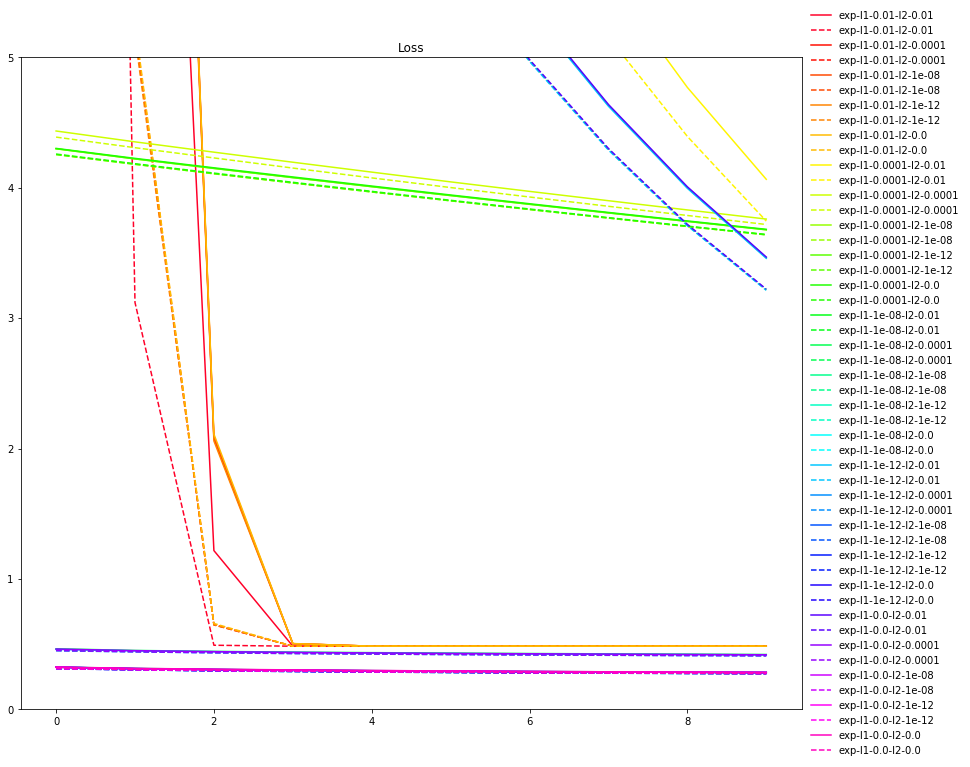

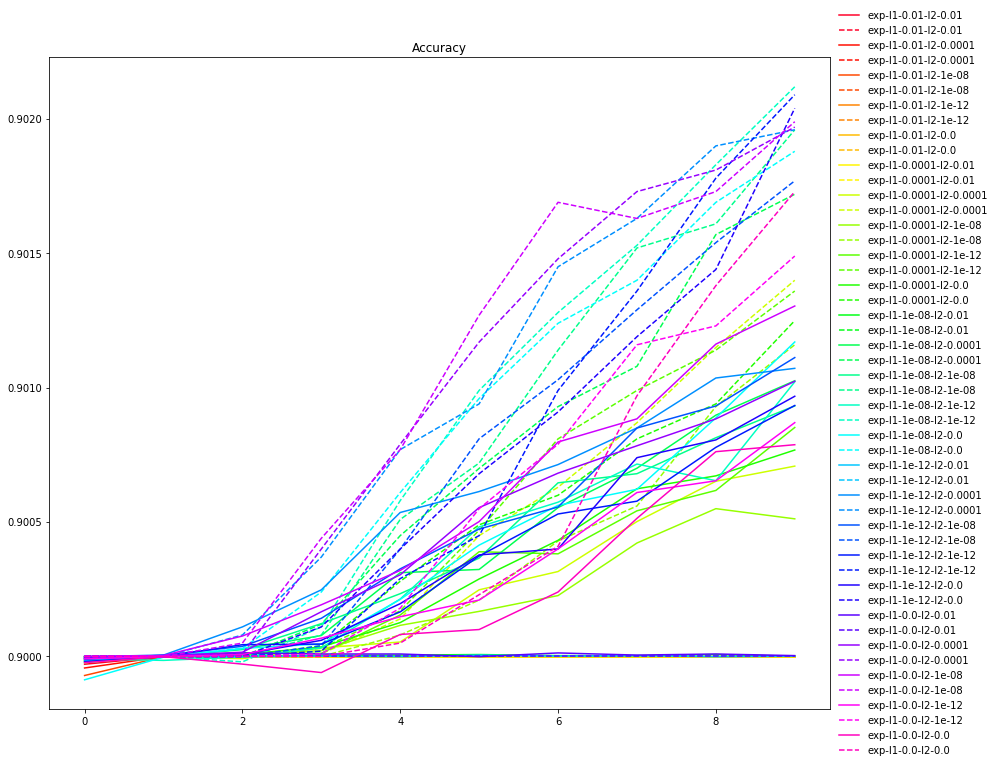

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.cm as mplcm
import matplotlib.colors as colors
NUM_COLORS = 25

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(14,12))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.show()

plt.figure(figsize=(14,12))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.show()

## 結論 : 以同樣的模型來看, 加入正規化的確有加速收斂的效果, 其中以L1=0, L2=1e-08組合表現最好.